In [1]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from concurrent.futures import ThreadPoolExecutor
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import pandas as pd
from tensorflow.keras.utils import plot_model

In [2]:
dict_gender = {
    0: 'male',
    1: 'female'
}
dict_race = {
    0: 'white',
    1: 'black',
    2: 'asian',
    3: 'indian',
    4: 'others'
}

dict_age = {
    0: 'child',
    1: 'teenager',
    2: 'adult',
    3: 'old',
}

In [3]:
def load_data(directory):
    dict_data = {
        'image': [],
        'age': [],
        'gender': [],
        'race': [],
    }
    for file in os.listdir(directory):
        label = file.split('_')
        dict_data['image'].append(directory + '/'+file)
        dict_data['age'].append(int(label[0]))
        dict_data['gender'].append(int(label[1]))
        dict_data['race'].append(int(label[2]))
    
    df_data = pd.DataFrame(dict_data)
    return df_data


In [4]:
df_data = load_data('data/UTKFace')

In [5]:
df_data.head()

,image,age,gender,race
0,data/UTKFace/100_0_0_20170112213500903.jpg.chi...,100,0,0
1,data/UTKFace/100_0_0_20170112215240346.jpg.chi...,100,0,0
2,data/UTKFace/100_1_0_20170110183726390.jpg.chi...,100,1,0
3,data/UTKFace/100_1_0_20170112213001988.jpg.chi...,100,1,0
4,data/UTKFace/100_1_0_20170112213303693.jpg.chi...,100,1,0


In [6]:
bins = [0, 12, 18, 40, 116]
labels = [0, 1, 2, 3]
df_data['age'] = pd.cut(df_data['age'], bins=bins, labels=labels)

In [ ]:
df_data

,image,age,gender,race
0,data/UTKFace/100_0_0_20170112213500903.jpg.chi...,3,0,0
1,data/UTKFace/100_0_0_20170112215240346.jpg.chi...,3,0,0
2,data/UTKFace/100_1_0_20170110183726390.jpg.chi...,3,1,0
3,data/UTKFace/100_1_0_20170112213001988.jpg.chi...,3,1,0
4,data/UTKFace/100_1_0_20170112213303693.jpg.chi...,3,1,0
...,...,...,...,...
23700,data/UTKFace/9_1_3_20161220222856346.jpg.chip.jpg,0,1,3
23701,data/UTKFace/9_1_3_20170104222949455.jpg.chip.jpg,0,1,3
23702,data/UTKFace/9_1_4_20170103200637399.jpg.chip.jpg,0,1,4
23703,data/UTKFace/9_1_4_20170103200814791.jpg.chip.jpg,0,1,4


In [ ]:
def plot_each_label(df):
    fig, ax = plt.subplots(1, 3, figsize=(20, 5))
    df['age'].value_counts().plot(kind='bar', ax=ax[0]).set_title('Age')
    df['gender'].value_counts().plot(kind='bar', ax=ax[1]).set_title('Gender')
    df['race'].value_counts().plot(kind='bar', ax=ax[2]).set_title('Race')
    plt.show()

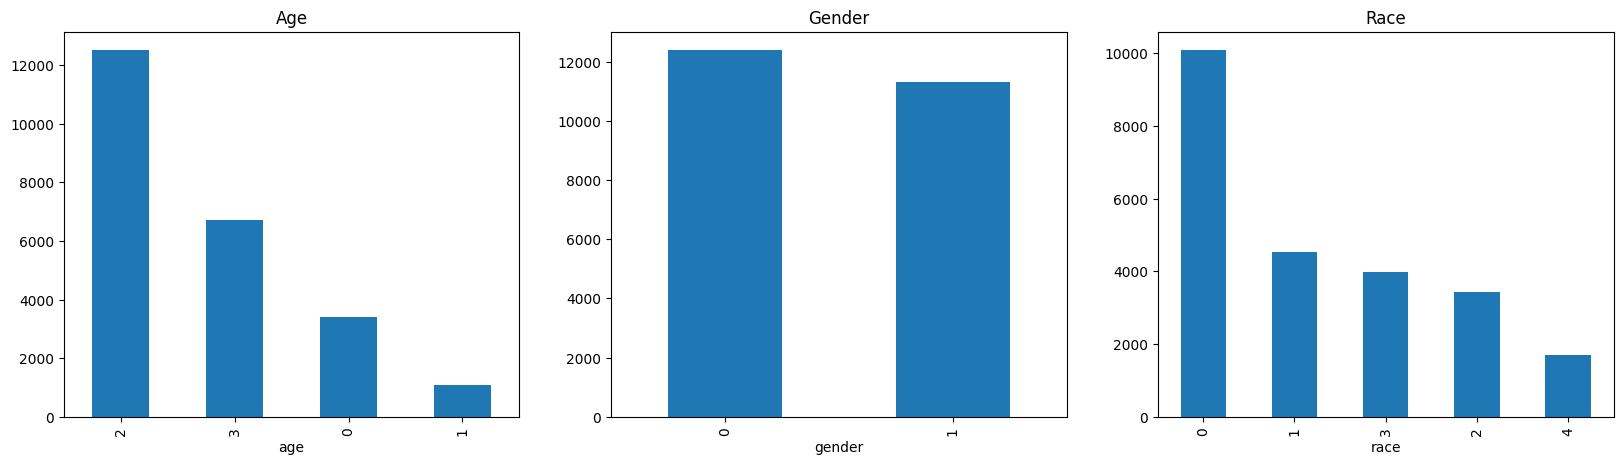

In [ ]:
plot_each_label(df_data)

In [ ]:
def plot_label_distribution(labels):
    unique_labels = np.unique(labels, axis=0)
    counts = np.zeros(len(unique_labels))
    for i, label in enumerate(unique_labels):
        counts[i] = np.sum(np.all(labels == label, axis=1))
    plt.figure(figsize=(10, 10))
    plt.barh(range(len(unique_labels)), counts)
    plt.ylabel('Labels')
    plt.xlabel('Count')
    plt.title('Label Distribution')
    plt.yticks(range(len(unique_labels)), [f'{dict_age[label[0]]} {dict_gender[label[1]]} {dict_race[label[2]]} {label}' for label in unique_labels], fontsize=8)
    for i, v in enumerate(counts):
        plt.text(v + 0.5, i, str(int(v)), va='center', fontsize=8)
    plt.show()

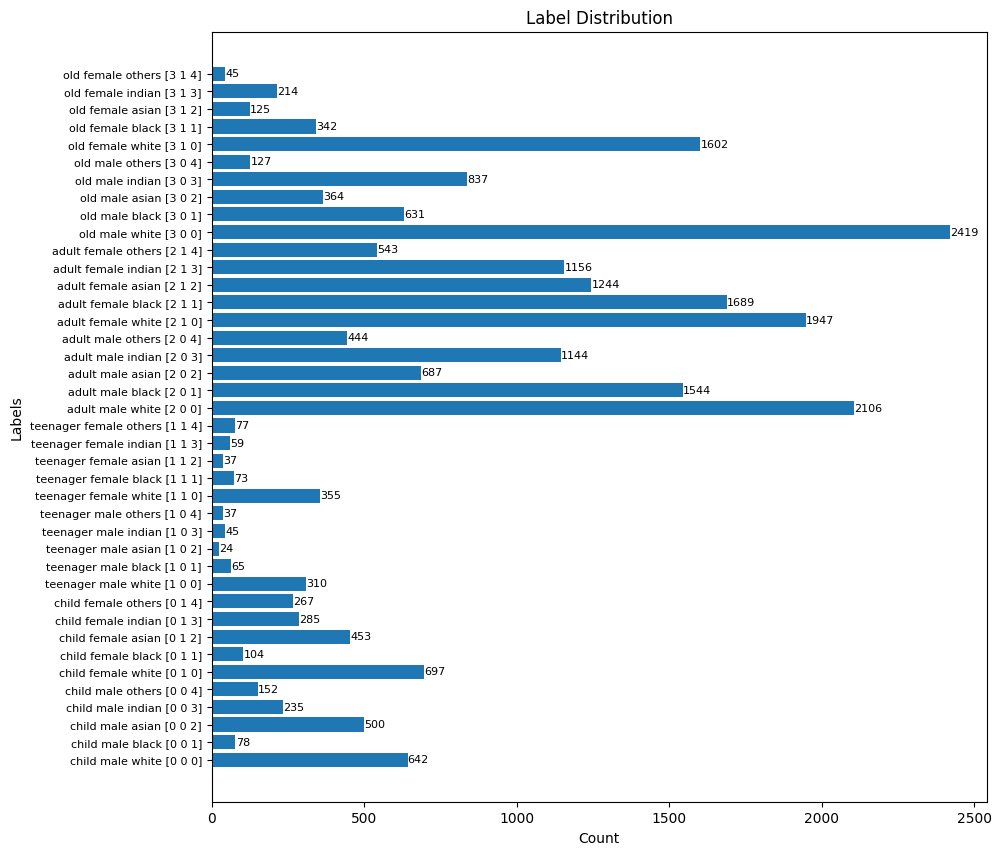

In [ ]:
plot_label_distribution(df_data[['age','gender', 'race']])

In [ ]:
def load_single_image(df, i):
    image = cv2.imread((df['image'][i]),cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image,(150, 150))
    label = [df['age'][i],df['gender'][i],df['race'][i]]
    return np.array(image, np.uint8), np.array(label, np.uint8)

def load_image(df):
    images = []
    labels = []
    with ThreadPoolExecutor(max_workers=12) as executor:
        for i in range(len(df)):
            image, label = executor.submit(load_single_image, df, i).result()
            images.append(image)
            labels.append(label)
    return np.array(images, np.uint8), np.array(labels, np.uint8)

In [ ]:
images, labels = load_image(df_data)
images.shape, labels.shape

((23705, 150, 150, 3), (23705, 3))

In [ ]:
del df_data

In [ ]:
def show_sample_images(images, labels, num_images=10):
    fig, axes = plt.subplots(1, num_images, figsize=(20, 20))
    for i in range(num_images):
        index = np.random.randint(0, len(images))
        axes[i].imshow(images[index])
        axes[i].set_title(f'{dict_age[labels[index][0]]}, {dict_gender[labels[index][1]]}, {dict_race[labels[index][2]]}', fontsize=8)
        axes[i].axis('off')
    plt.show()

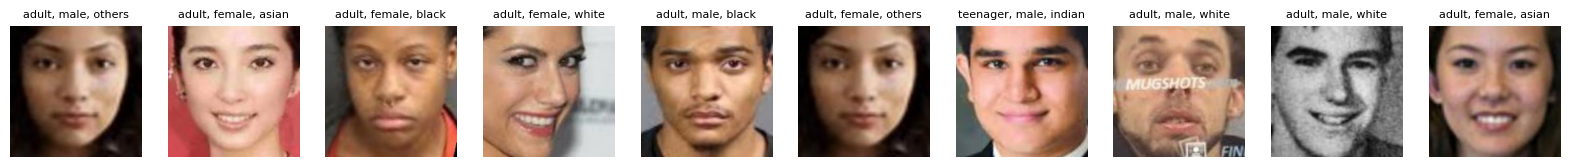

In [ ]:
show_sample_images(images, labels)

In [ ]:
def downsample(images, labels, n_samples):
    labels_as_tuples = [tuple(label) for label in labels]
    unique_labels = set(labels_as_tuples)
    downsampled_images = []
    downsampled_labels = []
    for label in unique_labels:
        indices = [i for i, lbl in enumerate(labels_as_tuples) if lbl == label]
        if len(indices) < n_samples:
            print(f"Warning: Class {label} only has {len(indices)} samples, less than {n_samples}")
            selected_indices = indices
        else:
            selected_indices = np.random.choice(indices, n_samples, replace=False)
        downsampled_images.extend(images[i] for i in selected_indices)
        downsampled_labels.extend(labels[i] for i in selected_indices)
    
    return np.array(downsampled_images), np.array(downsampled_labels)

In [ ]:
# images, labels = downsample(images, labels, 6000)

In [ ]:
def image_augmentation(images, labels, num_augmentations=5):
    augmented_images = []
    augmented_labels = []

    data_augmentation = ImageDataGenerator(
        rotation_range=10,
        zoom_range=0.1,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest',
    )

    for i in range(num_augmentations):
        augmented_images.extend(data_augmentation.flow(images, batch_size=len(images), shuffle=False).next())
        augmented_labels.extend(labels)

    augmented_images = np.array(augmented_images, np.uint8)
    augmented_labels = np.array(augmented_labels, np.uint8)
        
    return augmented_images, augmented_labels

In [ ]:
augmentation_params = [
    ([3, 1, 4], 10),
    # ([3, 1, 3], 10),
    # ([3, 1, 2], 10),
    # ([3, 1, 1], 6),
    ([3, 0, 4], 10),
    # ([3, 0, 3], 2),
    # ([3, 0, 2], 6),
    # ([3, 0, 1], 3),
    ([2, 1, 4], 3),
    # ([2, 1, 3], 1),
    # ([2, 1, 2], 1),
    ([2, 0, 4], 4),
    # ([2, 0, 3], 1),
    # ([2, 0, 2], 3),
    ([1, 1, 4], 10),
    ([1, 1, 3], 10),
    ([1, 1, 2], 10),
    ([1, 1, 1], 10),
    ([1, 1, 0], 10),
    ([1, 0, 4], 10),
    ([1, 0, 3], 10),
    ([1, 0, 2], 10),
    ([1, 0, 1], 10),
    ([1, 0, 0], 10),
    ([0, 1, 4], 10),
    # ([0, 1, 3], 9),
    # ([0, 1, 2], 4),
    # ([0, 1, 1], 10),
    # ([0, 1, 0], 3),
    ([0, 0, 4], 10),
    # ([0, 0, 3], 10),
    # ([0, 0, 2], 4),
    # ([0, 0, 1], 10),
    # ([0, 0, 0], 3),
]


batch_size = 64
for target_label, num_augmentations in augmentation_params:
    target_indices = [i for i, label in enumerate(labels) if np.all(label == target_label)]
    for i in range(0, len(target_indices), batch_size):
        batch_indices = target_indices[i:i+batch_size]
        target_images = images[batch_indices]
        target_labels = labels[batch_indices]
        augmented_images, augmented_labels = image_augmentation(target_images, target_labels, num_augmentations)
        
        images = np.concatenate((images, augmented_images), axis=0)
        labels = np.concatenate((labels, augmented_labels), axis=0)
    print(f'Augmentation for {target_label} done')

Augmentation for [3, 1, 4] done
Augmentation for [3, 0, 4] done
Augmentation for [2, 1, 4] done
Augmentation for [2, 0, 4] done
Augmentation for [1, 1, 4] done
Augmentation for [1, 1, 3] done
Augmentation for [1, 1, 2] done
Augmentation for [1, 1, 1] done
Augmentation for [1, 1, 0] done
Augmentation for [1, 0, 4] done
Augmentation for [1, 0, 3] done
Augmentation for [1, 0, 2] done
Augmentation for [1, 0, 1] done
Augmentation for [1, 0, 0] done
Augmentation for [0, 1, 4] done
Augmentation for [0, 0, 4] done


In [ ]:
images.shape, labels.shape

((43840, 150, 150, 3), (43840, 3))

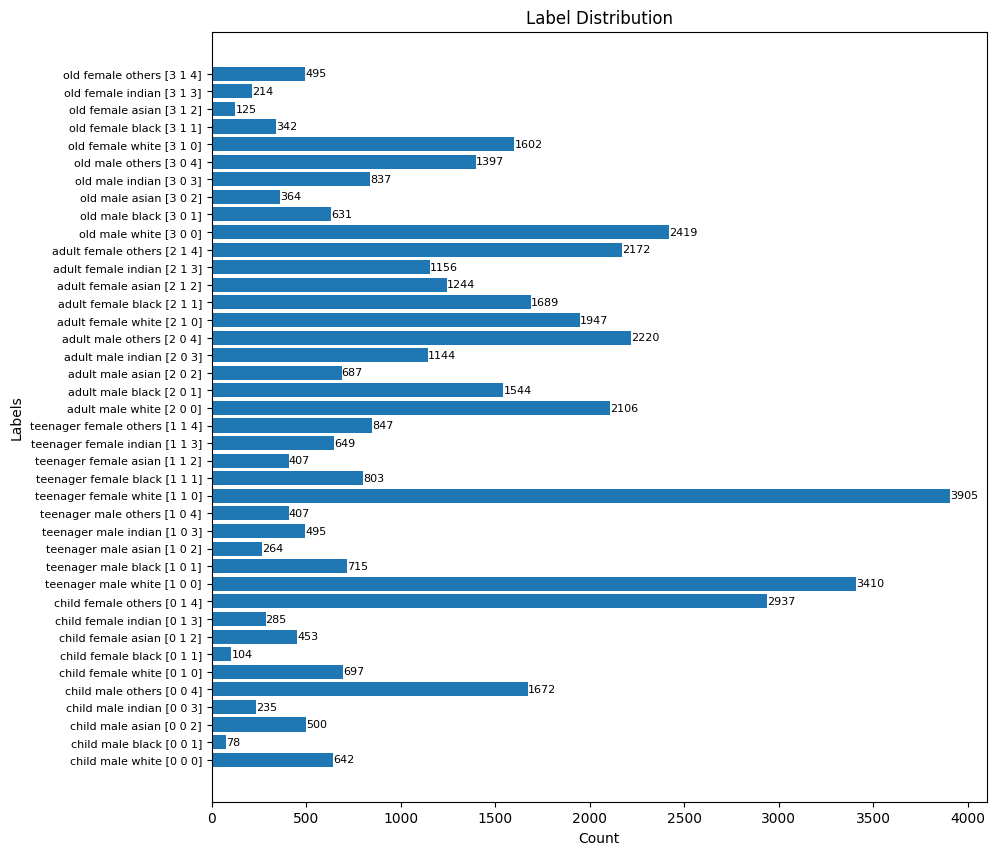

In [ ]:
plot_label_distribution(labels)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
y_train_1, y_train_2, y_train_3 = y_train[:,0], y_train[:,1], y_train[:,2]
y_test_1, y_test_2, y_test_3 = y_test[:,0], y_test[:,1], y_test[:,2]

In [ ]:
with tf.device('/cpu:0'):
    x_train = tf.convert_to_tensor(x_train)
    x_test = tf.convert_to_tensor(x_test)
    y_train_1 = tf.convert_to_tensor(y_train_1)
    y_train_2 = tf.convert_to_tensor(y_train_2)
    y_train_3 = tf.convert_to_tensor(y_train_3)
    y_test_1 = tf.convert_to_tensor(y_test_1)
    y_test_2 = tf.convert_to_tensor(y_test_2)
    y_test_3 = tf.convert_to_tensor(y_test_3)

In [ ]:
inputs = tf.keras.layers.Input(shape=(150, 150, 3))
x = tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(inputs)
x = tf.keras.layers.MaxPooling2D((2,2))(x)
x = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = tf.keras.layers.MaxPooling2D((2,2))(x)
x = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = tf.keras.layers.MaxPooling2D((2,2))(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dropout(0.5)(x)

dense_1 = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
dense_1 = tf.keras.layers.Dropout(0.2)(dense_1)
outputs_1 = tf.keras.layers.Dense(5, activation='softmax', name='age')(dense_1)

dense_2 = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
dense_2 = tf.keras.layers.Dropout(0.2)(dense_2)
outputs_2 = tf.keras.layers.Dense(1, activation='sigmoid', name='gender')(dense_2)

dense_3 = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
dense_3 = tf.keras.layers.Dropout(0.2)(dense_3)
outputs_3 = tf.keras.layers.Dense(5, activation='softmax', name='race')(dense_3)

model = tf.keras.models.Model(inputs=inputs, outputs=[outputs_1, outputs_2, outputs_3])
model.compile(optimizer='adam', loss=['sparse_categorical_crossentropy', 'binary_crossentropy', 'sparse_categorical_crossentropy'], metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 150, 150, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 75, 75, 32)   0           ['conv2d[0][0]']                 
                                                                                              

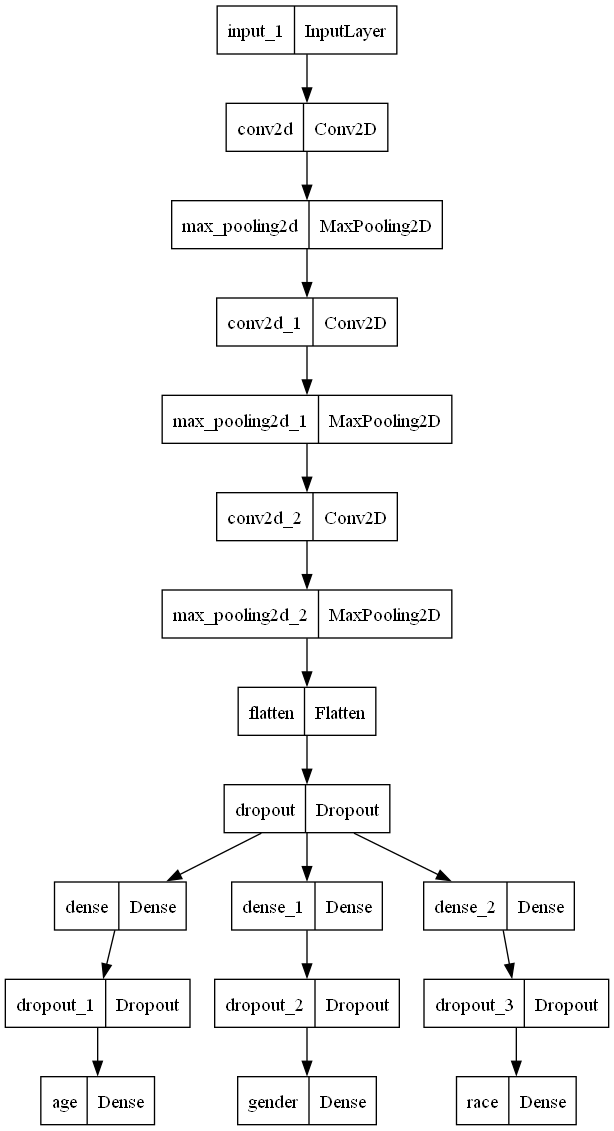

In [ ]:
plot_model(model)

In [ ]:
history = model.fit(x_train, [y_train_1, y_train_2, y_train_3], validation_data=(x_test, [y_test_1, y_test_2, y_test_3]), epochs=50, batch_size=64)

Epoch 1/50
548/548 [==============================] - 60s 102ms/step - loss: 11.8825 - age_loss: 3.7107 - gender_loss: 2.6793 - race_loss: 4.0337 - age_accuracy: 0.5104 - gender_accuracy: 0.7076 - race_accuracy: 0.4837 - val_loss: 3.7637 - val_age_loss: 0.9498 - val_gender_loss: 0.4695 - val_race_loss: 1.0956 - val_age_accuracy: 0.6111 - val_gender_accuracy: 0.7843 - val_race_accuracy: 0.5854
Epoch 2/50
548/548 [==============================] - 58s 106ms/step - loss: 3.7443 - age_loss: 0.9632 - gender_loss: 0.4939 - race_loss: 1.1297 - age_accuracy: 0.5896 - gender_accuracy: 0.7555 - race_accuracy: 0.5563 - val_loss: 3.3753 - val_age_loss: 0.8201 - val_gender_loss: 0.4228 - val_race_loss: 1.0058 - val_age_accuracy: 0.6816 - val_gender_accuracy: 0.8152 - val_race_accuracy: 0.6349
Epoch 3/50
548/548 [==============================] - 56s 103ms/step - loss: 3.4131 - age_loss: 0.8923 - gender_loss: 0.4594 - race_loss: 1.0541 - age_accuracy: 0.6293 - gender_accuracy: 0.7797 - race_accuracy

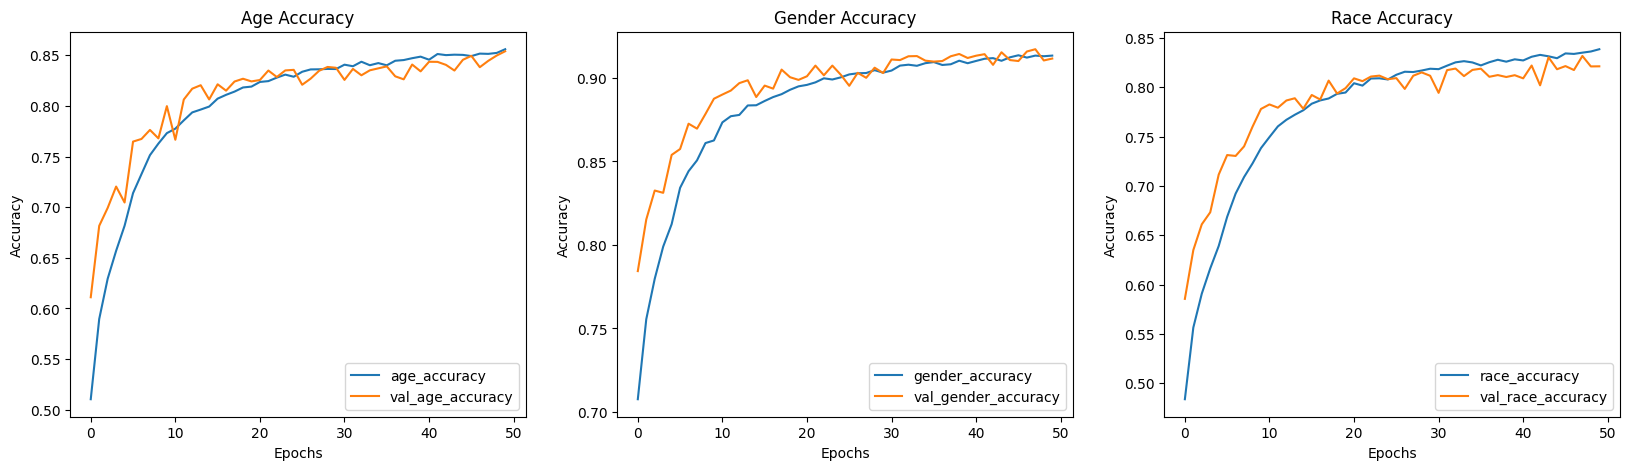

In [ ]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
plt.plot(history.history['age_accuracy'], label='age_accuracy')
plt.plot(history.history['val_age_accuracy'], label='val_age_accuracy')
plt.title('Age Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history.history['gender_accuracy'], label='gender_accuracy')
plt.plot(history.history['val_gender_accuracy'], label='val_gender_accuracy')
plt.title('Gender Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history.history['race_accuracy'], label='race_accuracy')
plt.plot(history.history['val_race_accuracy'], label='val_race_accuracy')
plt.title('Race Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [ ]:
y_pred = model.predict(x_test)
y_pred_age = np.argmax(y_pred[0], axis=1)
y_pred_gender = np.round(y_pred[1])
y_pred_race = np.argmax(y_pred[2], axis=1)

274/274 [==============================] - 3s 11ms/step


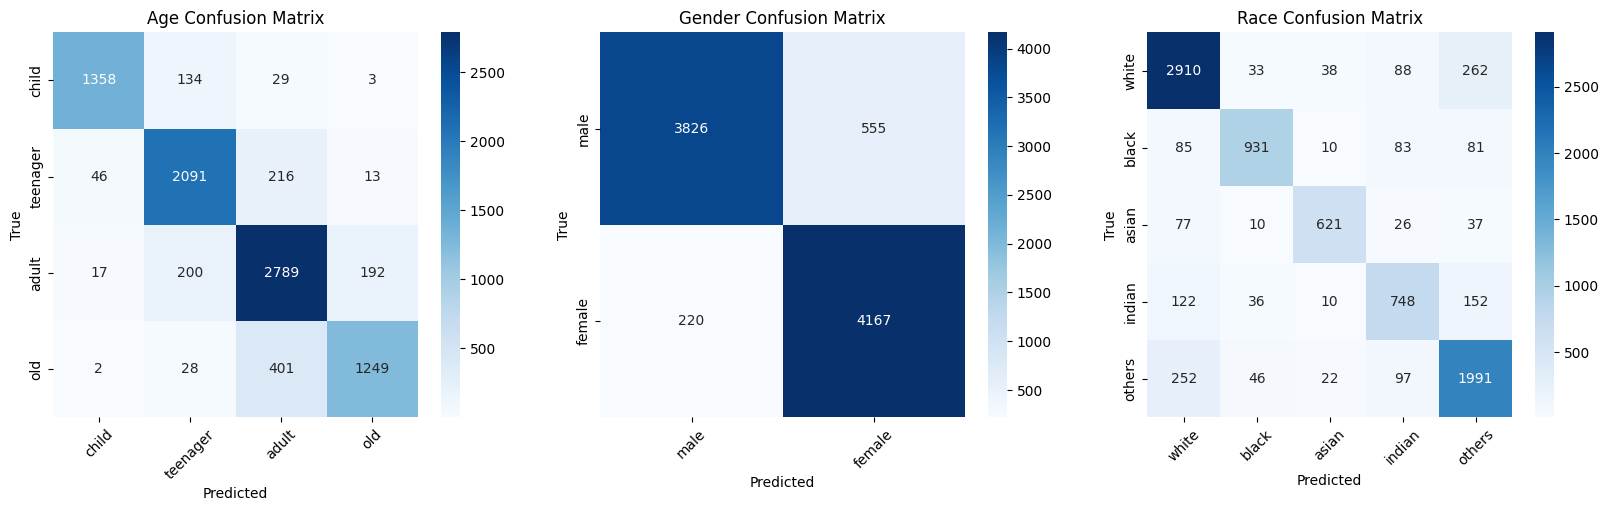

In [ ]:
plt.figure(figsize=(20, 5))

plt.subplot(1, 3, 1)
sns.heatmap(confusion_matrix(y_test_1, y_pred_age), annot=True, fmt='d', cmap='Blues', xticklabels=dict_age.values(), yticklabels=dict_age.values())
plt.title('Age Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)

plt.subplot(1, 3, 2)
sns.heatmap(confusion_matrix(y_test_2, y_pred_gender), annot=True, fmt='d', cmap='Blues', xticklabels=dict_gender.values(), yticklabels=dict_gender.values())
plt.title('Gender Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)

plt.subplot(1, 3, 3)
sns.heatmap(confusion_matrix(y_test_3, y_pred_race), annot=True, fmt='d', cmap='Blues', xticklabels=dict_race.values(), yticklabels=dict_race.values())
plt.title('Race Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)

plt.show()

In [ ]:
print(classification_report(y_test_1, y_pred_age, target_names=dict_age.values()))

              precision    recall  f1-score   support

       child       0.95      0.89      0.92      1524
    teenager       0.85      0.88      0.87      2366
       adult       0.81      0.87      0.84      3198
         old       0.86      0.74      0.80      1680

    accuracy                           0.85      8768
   macro avg       0.87      0.85      0.86      8768
weighted avg       0.86      0.85      0.85      8768



In [ ]:
print(classification_report(y_test_2, y_pred_gender, target_names=dict_gender.values()))

              precision    recall  f1-score   support

        male       0.95      0.87      0.91      4381
      female       0.88      0.95      0.91      4387

    accuracy                           0.91      8768
   macro avg       0.91      0.91      0.91      8768
weighted avg       0.91      0.91      0.91      8768



In [ ]:
print(classification_report(y_test_3, y_pred_race, target_names=dict_race.values()))

              precision    recall  f1-score   support

       white       0.84      0.87      0.86      3331
       black       0.88      0.78      0.83      1190
       asian       0.89      0.81      0.84       771
      indian       0.72      0.70      0.71      1068
      others       0.79      0.83      0.81      2408

    accuracy                           0.82      8768
   macro avg       0.82      0.80      0.81      8768
weighted avg       0.82      0.82      0.82      8768



In [ ]:
# model.save('model_age_gender_race.h5')

In [ ]:
# model.save_weights('checkpoint/cp_1.ckpt')